In [4]:
import os

component_dir = "./components"
os.makedirs(component_dir, exist_ok=True)

src_dir = "./components/src_manager"
os.makedirs(src_dir, exist_ok=True)

In [13]:
%%writefile $component_dir/manager.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: manager
display_name: manager
is_deterministic: false
version: 0.21
type: command
inputs:
  brokerAddress:
    type: string
    description: "Broker address"
  nb_consumers_producers:
    type: integer
    description: "Number of consumers and producers"
code: ./src_manager
environment: azureml:kafka-custom-env@latest
command: >-
  python manager.py
  --brokerAddress ${{inputs.brokerAddress}}
  --nb_consumers_producers ${{inputs.nb_consumers_producers}}
  

Overwriting ./components/manager.yml


In [1]:
%%writefile {src_dir}/manager.py
import argparse
import time
from kafka import KafkaProducer
from kafka import KafkaConsumer
import json
import random
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy import var
from numpy import mean
from numpy import percentile
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import sys
import mlflow

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat = surrogate(model, X)
	best = yhat.max()
	# calculate mean via surrogate function
	mu = surrogate(model, Xsamples)
	# calculate the stdev

	mu = mu[:]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (mu.std()+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(5) * 9800 + 200

	# add values to the sample that are close to the current best samples
	# get the current best samples
	bestX = X[argmax(y)]
	# add 10 samples that are close to the current best samples
	Xsampples2 = bestX + random(5)*250
	
	# add the new samples to the old samples within 1 dimension
	Xsamples = vstack((Xsamples, Xsampples2))
	Xsamples = Xsamples.ravel()


	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
    # scatter plot of inputs and real objective function
    pyplot.scatter(X, y)
    # line plot of surrogate function across domain
    Xsamples = asarray(arange(200, 2000, 10))
    Xsamples = Xsamples.reshape(len(Xsamples), 1)
    ysamples = surrogate(model, Xsamples)
    pyplot.plot(Xsamples, ysamples)
    # save plot to file
    mlflow.log_figure(pyplot.gcf(), "plot" + str(time.time()) + ".png")

# Create the data of the producer
def create_data_json(batch_size, flow):
    data = {}
    data["batch_size"] = batch_size
    data["flow"] = flow
    data["amount_of_time"] = 30
    data["timestamp"] = time.time()
    data["stop"] = False
    return data

# Send data
def send_new_try(brokerAddress, topic, batch_size, flow):
    
    producer = KafkaProducer(
            bootstrap_servers=brokerAddress,
            api_version=(0, 10, 1),
            acks=1,)
    data = create_data_json(batch_size, flow)
    data_encode = json.dumps(data).encode('utf-8')
    
    producer.send(topic, data_encode)

    # Flush and close the producer to ensure all messages are sent
    producer.flush()
    producer.close()

def delete_and_average(the_list):

    q1 = percentile(the_list, 25)
    q3 = percentile(the_list, 75)


    iqr = q3 - q1

    lower_bound = q1 - (iqr * 1)
    upper_bound = q3 + (iqr * 1)

    new_list = [x for x in the_list if x >= lower_bound and x <= upper_bound]

    for _ in range(0, 2):
        variance = var(new_list)
        best_var = variance
        if len(new_list) > 2:
            for i in range(0, len(new_list)):
                test = new_list.copy()
                test.pop(i)
                # get the best variance and keep the index
                if var(test) < best_var:
                    best_var = var(test)
                    index = i
        if best_var * 2.5 < variance:
            new_list.pop(index)
    return mean(new_list)

def stop_experiment(brokerAddress):
	producer = KafkaProducer(
			bootstrap_servers=brokerAddress,
			api_version=(0, 10, 1),
			acks=1,)
	data = {"stop": True}
	data_encode = json.dumps(data).encode('utf-8')
	producer.send("manager-producer", data_encode)

	# Flush and close the producer to ensure all messages are sent
	producer.flush()
	producer.close()

# Start the experiment
def start_experiment(flow, brokerAddress, nb_consumers_producers):
	amount_of_ko = 10
	batch_size = amount_of_ko*1024*1.2
	# Send the data to the producer
	send_new_try(brokerAddress, "manager-producer", batch_size, (int)(flow/nb_consumers_producers))

	# Wait for the end of the experiment
	time.sleep(10)
	
	# Get the result
	result = get_result(brokerAddress, nb_consumers_producers, flow)
	
	return result

def print_debug(message, brokerAddress):
    producer = KafkaProducer(
			bootstrap_servers=brokerAddress,
			api_version=(0, 10, 1),
			acks=1,)
    data = {"message": message}
    data_encode = json.dumps(data).encode('utf-8')
    producer.send("debug", data_encode)


# Get the result
def get_result(brokerAddress, nb_consumers_producers, flow):
    consumer = KafkaConsumer(
            bootstrap_servers=brokerAddress,
            api_version=(0, 10),)

    consumer.subscribe(["manager-consumer"])

    # Get the result
    result = {}
    list_time = []

    for _ in range(nb_consumers_producers):
        print("Waiting for the result")
        print("Received so far: ", len(list_time))
        producer = KafkaProducer(
            bootstrap_servers=brokerAddress,
            api_version=(0, 10, 1),
            acks=1,)
        data = {"Received so far:": len(list_time),
                "nb_consumers_producers": nb_consumers_producers}
        data_encode = json.dumps(data).encode('utf-8')
        producer.send("debug", data_encode)
        # Flush and close the producer to ensure all messages are sent
        producer.flush()
        producer.close()

        for message in consumer:
            data = json.loads(message.value.decode('utf-8'))
            
            list_time.append(data["time"])
            if result == {}:
                result["machine_kafka"] = data["machine_kafka"]
                result["batch_size"] = data["batch_size"]
                result["flow"] = flow
            break

    consumer.close()

    result["time"] = delete_and_average(list_time)
    return result["time"]

# Get the result
def wait_consumer(brokerAddress, nb_consumers_producers):
    consumer = KafkaConsumer(
            bootstrap_servers=brokerAddress,
            api_version=(0, 10),)

    consumer.subscribe(["manager-consumer"])
    cpt = 0

    for _ in range(nb_consumers_producers):
        print("Waiting for the result")
        print("Received so far: ", cpt)
        producer = KafkaProducer(
            bootstrap_servers=brokerAddress,
            api_version=(0, 10, 1),
            acks=1,)
        
        print_debug("Received so far:"+ str(cpt)+
            "nb_consumers_producers :"+  str(nb_consumers_producers, brokerAddress))
        # Flush and close the producer to ensure all messages are sent
        producer.flush()
        producer.close()

        for _ in consumer:
            cpt += 1
            break

    consumer.close()
    return 

def calculate_score(t, x):
	# Constraints on the time
	if t < 0.2:
		t = 0.01
	elif t < 0.3:
		t = 0.2
	elif t < 0.4:
		t = 0.4
	elif t < 0.6:
		t = 1
	elif t < 0.8:
		t = 1.5
	else:
		t = 4
	score = x + ((t*30)**2)
	if score < 0:
		score = score * 0.01
	return score

def main():
    """Main function of the script."""

    # input and output arguments
    parser = argparse.ArgumentParser()
    parser.add_argument("--brokerAddress", type=str, help="Broker address")
    parser.add_argument("--nb_consumers_producers", type=int, help="Number of consumers and producers")

    args = parser.parse_args()

    nb_consumers_producers = args.nb_consumers_producers

    print("I am the manager\n")
    mlflow.start_run()
    time.sleep(500)

    brokerAddress = args.brokerAddress.split(" ")
    for i in range(len(brokerAddress)):
        brokerAddress[i] = brokerAddress[i] + ":9094"

    print("brokerAddress: ", brokerAddress)

    # Create the data of the producer
    # get a representative sample of the domain
    X = asarray(arange(250, 10001,500))
    y = asarray([start_experiment(x, brokerAddress, nb_consumers_producers) for x in X])

    # reshape into rows and cols
    X = X.reshape(len(X), 1)
    y = y.reshape(len(y), 1)
    print("This is the data before redoing the bad ones", file=sys.stderr)
    print("x: ", X)
    print("y: ", y)

    # Check the data
    list_to_redo = []
    after = y[1]
    for i in range(len(y)):
        if y[i] > after and y[i] < 10:
            list_to_redo.append(i)
        after = y[(i+1)%len(y)]
    for i in list_to_redo:
        y[i] = start_experiment(X[i], brokerAddress, nb_consumers_producers)
    print("This is the data after redoing the bad ones")
    print("x: ", X)
    print("y: ", y)

    y_save = y

    y = asarray([calculate_score(X[i], y[i]) for i in range(len(y))])
    y = y.reshape(len(y), 1)

    # define the model
    model = RandomForestRegressor()
    # fit the model
    model.fit(X, y.reshape(-1))
    # plot before hand
    plot(X, y, model)
    # perform the optimization process
    for i in range(5):
        # select the next point to sample
        x = opt_acquisition(X, y, model)
        print("This is the next point to sample :")
        print(x)
        # sample the point
        time_calculated = start_experiment(x, brokerAddress, nb_consumers_producers)
        y_save = vstack((y_save, [[time_calculated]]))
        actual = calculate_score(x, time_calculated)
        # summarize the finding
        est = surrogate(model, [[x]])
        # print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
        # add the data to the dataset
        X = vstack((X, [[x]]))
        y = vstack((y, [[actual]]))
        # update the model
        model.fit(X, y.reshape(-1))

        # plot all samples and the final surrogate function
    plot(X, y, model)
        # best result
    ix = argmax(y)
    print("This is the data after the optimization")
    print("x: ", X)
    print("y: ", y_save)

    print('Best Result: x=%.3f, y=%.3f with complexity : %d' % (X[ix], y[ix], X.shape[0]))
    time.sleep(20)
    stop_experiment(brokerAddress)

    # Stop Logging
    mlflow.end_run()

if __name__ == "__main__":
    main()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Writing {src_dir}/manager.py


FileNotFoundError: [Errno 2] No such file or directory: '{src_dir}/manager.py'

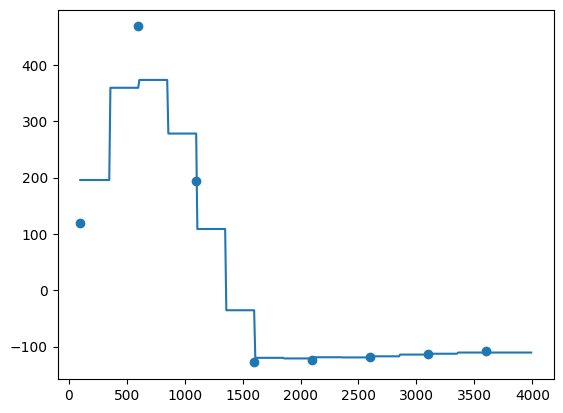

698.59373941547
727.9732624012499
778.3266676696395
843.3445249831773


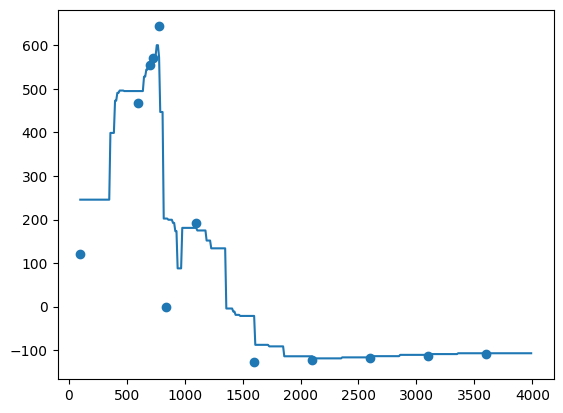

Best Result: x=778.327, y=643.115 with complexity : 12


In [2]:
# example of bayesian optimization for a 1d function from scratch
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import time

def timeCalculation(x):
    return ((x/2000.)**2 * sin(5 * pi * (x/2000.))**6.0) + x/2000.

# objective function
def objective(x, noise=10):
	noise = normal(loc=0, scale=noise)
	t = timeCalculation(x)
	if t < 0.2:
		t = 0.01
	elif t < 0.3:
		t = 0.2
	elif t < 0.4:
		t = 0.4
	elif t < 0.6:
		t = 1
	elif t < 0.8:
		t = 1.5
	else:
		t = 4
	score = x + noise - ((t*30)**2)
	if score < 0:
		score = score * 0.01
	return score

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat = surrogate(model, X)
	best = yhat.max()
	# calculate mean via surrogate function
	mu = surrogate(model, Xsamples)
	# calculate the stdev

	mu = mu[:]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (mu.std()+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(5) * 1800 + 200

	# add values to the sample that are close to the current best samples
	# get the current best samples
	bestX = X[argmax(y)]
	# add 10 samples that are close to the current best samples
	Xsampples2 = bestX + random(5)*250
	
	# add the new samples to the old samples within 1 dimension
	Xsamples = vstack((Xsamples, Xsampples2))
	Xsamples = Xsamples.ravel()


	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(100, 4000, 10))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# get a representative sample of the domain
X = asarray(arange(100, 4000,500))
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y.reshape(-1))
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(4):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	print(x)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est = surrogate(model, [[x]])
	# print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y.reshape(-1))

	# plot all samples and the final surrogate function
plot(X, y, model)
	# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f with complexity : %d' % (X[ix], y[ix], X.shape[0]))